## 1차 과제 - 고객 유지/이탈 자유 분석
- 주제: 가입 고객 이탈 데이터를 분석하여 기업에 인사이트 제공
- 데이터: Customer Churn Data(train data가 따로 있으나 너무 커서 test data만 사용, 예측 성능 향상을 원한다면 train data 사용해도 무방)
https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset?select=customer_churn_dataset-training-master.csv
- 사용 라이브러리: 자유

본 과제는 여러분들의 실력을 확인하고자 출제한 과제로 어떠한 가이드라인도 제공하거나 제약하지 않으며 자유롭게 분석하시면 됩니다.

분석이나 예측 어느 쪽이든 상관없으며 몇가지 조건만 유의하여 주시기 바랍니다.

### 조건
1. 기본적인 분석 과정은 EDA(데이터 탐색) > 전처리 > 분석(예측) 진행 > 결과 해석 으로 진행되지만 약간의 수정 허용
2. EDA 과정에서 최소 2개의 시각화 모형(그래프) 사용
3. 분석 및 예측 시 최소 2개의 모형(모델) 사용
4. 전처리는 자유롭게 진행하며 추가적인 데이터 사용이 필요하다면 허용

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier)
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_curve, classification_report

In [2]:
# 한글 폰트 오류 해결
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" 
# 맑은 폰트

font_name = font_manager.FontProperties(fname = font_path).get_name()
rc("font", family = font_name)

# 데이터 이해과정(EDA)

In [3]:
df = pd.read_csv("./data/customer_churn_dataset.csv")

In [4]:
df.head()
# Tenure: 가입 기간
# Last interaction : 최종 전환 이전 고객과의 상호작용

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [5]:
df.dtypes

CustomerID            int64
Age                   int64
Gender               object
Tenure                int64
Usage Frequency       int64
Support Calls         int64
Payment Delay         int64
Subscription Type    object
Contract Length      object
Total Spend           int64
Last Interaction      int64
Churn                 int64
dtype: object

In [6]:
# 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


In [7]:
df.isnull().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [8]:
# 특정 컬럼 제외하고 값이 0인 것이 있을수도 있으므로 확인 필요
check_zero = ["Age", "Tenure", "Usage Frequency", "Support Calls", "Payment Delay", "Total Spend", "Last Interaction"]
zero = df[check_zero] == 0

In [9]:
zero.sum()

Age                    0
Tenure                 0
Usage Frequency        0
Support Calls       4967
Payment Delay       1594
Total Spend            0
Last Interaction       0
dtype: int64

- 지원 전화 및 결제 지연같은 경우 0값도 당연히 존재
- 나머지 나이나 유지 기간 및 비용에서 0은 없음을 확인

In [10]:
# 빠르게 churn데이터 확인해 보기
df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000
mean,32187.500000,41.970982,31.994827,15.080234,5.400690,17.133952,541.023379,15.498850,0.473685
std,18583.317451,13.924911,17.098234,8.816470,3.114005,8.852211,260.874809,8.638436,0.499311
min,1.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,16094.250000,30.000000,18.000000,7.000000,3.000000,10.000000,313.000000,8.000000,0.000000
50%,32187.500000,42.000000,33.000000,15.000000,6.000000,19.000000,534.000000,15.000000,0.000000
75%,48280.750000,54.000000,47.000000,23.000000,8.000000,25.000000,768.000000,23.000000,1.000000
max,64374.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [11]:
df["Subscription Type"].value_counts()

Subscription Type
Standard    21502
Basic       21451
Premium     21421
Name: count, dtype: int64

In [12]:
df["Contract Length"].value_counts()

Contract Length
Monthly      22130
Annual       21410
Quarterly    20834
Name: count, dtype: int64

In [13]:
df["Churn"].value_counts()

Churn
0    33881
1    30493
Name: count, dtype: int64

In [14]:
df["Gender"].value_counts()

Gender
Female    34353
Male      30021
Name: count, dtype: int64

In [15]:
# Gender, Subscription Type, Contract Length
# LabelEncoding 진행하기

le = LabelEncoder()

- 라벨인코딩의 경우 범주형 변수를 숫자 크기로 인해 오해하는 경우가 발생할 수 있음
  - 라벨 인코딩으로 로지스틱 회귀를 먼저 진행해 보되, 성능이 떨어진다고 판단되면 원핫인코딩으로 진행할 필요가 있음

In [16]:
df["Gender"] = le.fit_transform(df["Gender"])
df["Subscription Type"] = le.fit_transform(df["Subscription Type"])
df["Contract Length"] = le.fit_transform(df["Contract Length"])

In [17]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,0,25,14,4,27,0,1,598,9,1
1,2,41,0,28,28,7,13,2,1,584,20,0
2,3,47,1,27,10,2,29,1,0,757,21,0
3,4,35,1,9,12,5,17,1,2,232,18,0
4,5,53,0,58,24,9,2,2,0,533,18,0


- Gender 컬럼
  - 여자는 0
  - 남자는 1

- Subscription Type 컬럼
  - Basic은 0
  - Standard는 1
  - Premium은 2

- Contract Length 컬럼
  - Annual은 0
  - Monthly는 1
  - Quaterly는 2

## EDA과정 중 데이터 시각화

In [18]:
df = df.drop("CustomerID", axis =1)
df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,22,0,25,14,4,27,0,1,598,9,1
1,41,0,28,28,7,13,2,1,584,20,0
2,47,1,27,10,2,29,1,0,757,21,0
3,35,1,9,12,5,17,1,2,232,18,0
4,53,0,58,24,9,2,2,0,533,18,0


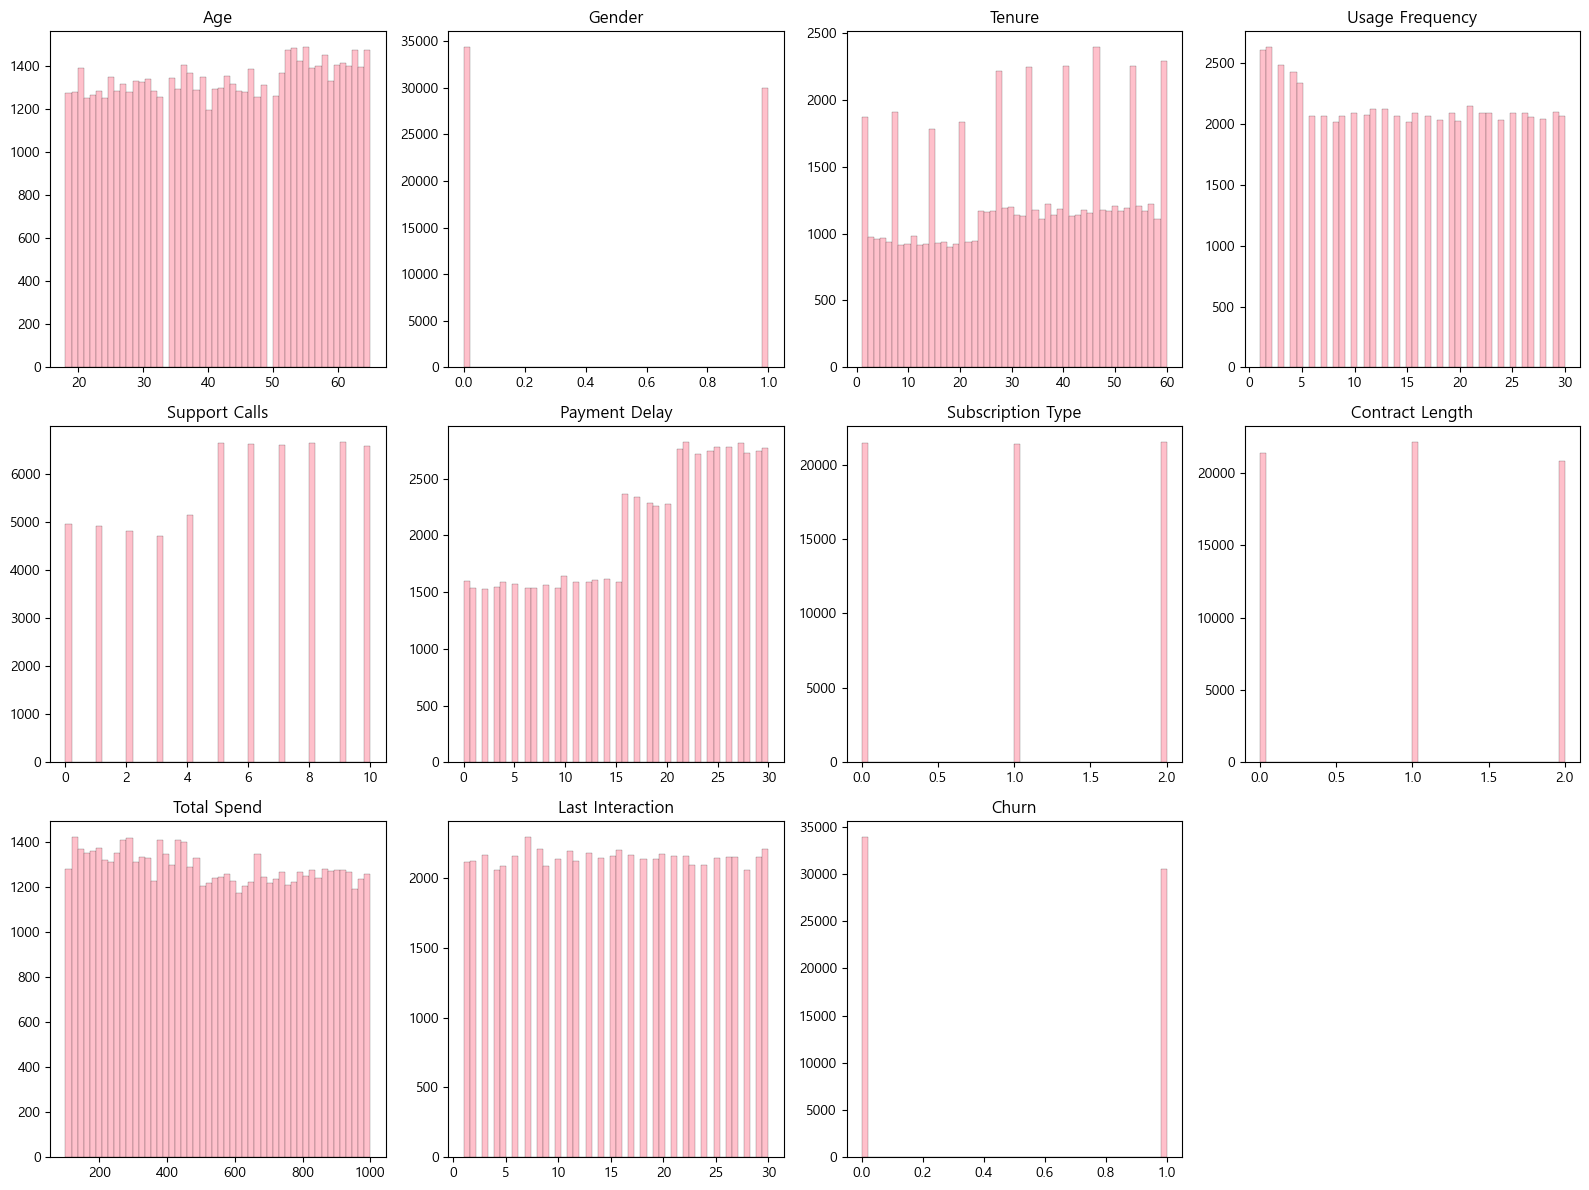

In [53]:
# 데이터 시각화 - 히스토그램
fig = plt.figure(figsize = (16,12))

for i in range(len(df.columns)):
    ax = fig.add_subplot(3, 4, i+1)
    plt.hist(df[df.columns[i]], bins = 50, color="pink", edgecolor = "black", linewidth = 0.14)
    ax.set_title(df.columns[i])

plt.tight_layout()
plt.show()

In [25]:
# 각 변수들간의 상관관계 확인하기
cor_cols = df.columns[:]
df_corr = df[cor_cols].corr()
df_corr

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
Age,1.000000,0.001800,-0.007763,-0.038331,0.005014,-0.016132,0.004472,0.000093,0.006490,-0.000148,0.063457
Gender,0.001800,1.000000,0.029418,-0.006907,0.035418,-0.058578,0.006374,-0.008933,0.029337,-0.000472,-0.164549
Tenure,-0.007763,0.029418,1.000000,0.023485,0.060065,0.055963,0.004202,0.000730,0.009474,0.005770,0.195327
Usage Frequency,-0.038331,-0.006907,0.023485,1.000000,-0.014072,0.031132,-0.000649,0.011288,0.001527,-0.009192,-0.115098
Support Calls,0.005014,0.035418,0.060065,-0.014072,1.000000,0.064298,-0.003178,-0.003080,0.021750,0.001666,0.304631
Payment Delay,-0.016132,-0.058578,0.055963,0.031132,0.064298,1.000000,-0.001510,0.001937,-0.031119,-0.008076,0.557386
Subscription Type,0.004472,0.006374,0.004202,-0.000649,-0.003178,-0.001510,1.000000,-0.000036,-0.003636,-0.002227,-0.007738
Contract Length,0.000093,-0.008933,0.000730,0.011288,-0.003080,0.001937,-0.000036,1.000000,0.006638,0.003859,-0.017098
Total Spend,0.006490,0.029337,0.009474,0.001527,0.021750,-0.031119,-0.003636,0.006638,1.000000,-0.007692,-0.078867
Last Interaction,-0.000148,-0.000472,0.005770,-0.009192,0.001666,-0.008076,-0.002227,0.003859,-0.007692,1.000000,-0.002818


- 상관계수를 확인한 결과 Payment Delay와 Support Calls 두 컬럼이 Churn 컬럼과 가장 높은 상관관계를 보임
- 그 다음 3번째로 양의 상관관계를 보이는 것이 Tenure칼럼으로, 0.195임을 확인
  - 라벨 인코딩을 진행한 Gender, Subscription Types, Contract Length는 Churn과 상관성이 보이지 않는다고 판단
    - (원핫 인코딩으로 진행해본 결과 역시 상관성이 매우 낮게 나오기에 마찬가지로 생략)
- 상관관계가 0.75이상인 변수들이 없으며, 그나마 높은 값의 변수조차도 중복되는 것이 없기에 **다중공선성은 매우 낮다고 판단**

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


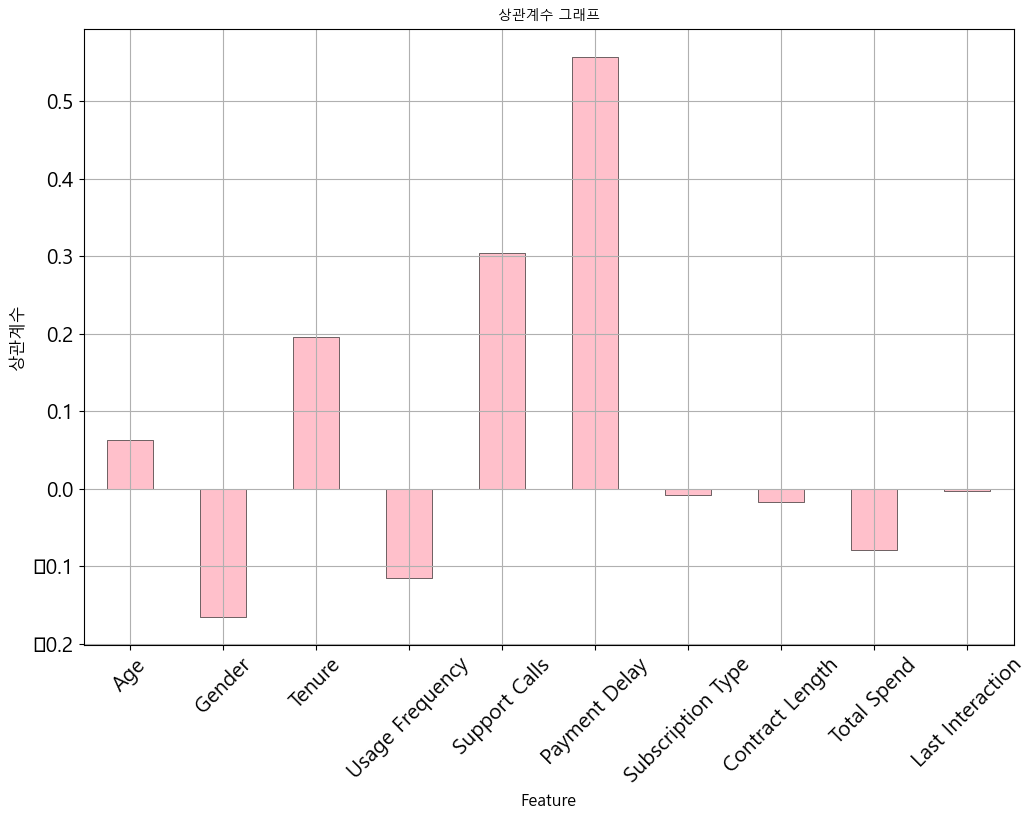

In [56]:
# 그래프 그려보기
plt.figure(figsize=(12,8))

df_corr.drop("Churn", inplace = False)["Churn"].plot(kind="bar", 
                            fontsize=15, 
                            color="pink",
                            edgecolor="black",
                            linewidth=0.4,
                            rot=45, 
                            grid=True)

plt.title("상관계수 그래프", fontsize=10)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("상관계수", fontsize=12)
plt.xticks(horizontalalignment="center")

plt.show()

# No1. 로지스틱 회귀분석

## 상관계수가 -0.1 이하 또는 0.1 이상인 컬럼을 대상으로 진행

- 로지스틱 회귀를 선택한 이유
  - 데이터셋이 비교적 단순하 크기 역시 65,000개 정도로 작기 때문
  - 변수들 간에 다중공선성(VIF)이 거의 존재하지 않는다고 판단했기 때문
    - 상관계수들 중 +-0.75를 넘는 큰 값이 일단 없으며, 상대적으로 서로 상관계수들이 겹치지 않기 때문

In [57]:
df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,22,0,25,14,4,27,0,1,598,9,1
1,41,0,28,28,7,13,2,1,584,20,0
2,47,1,27,10,2,29,1,0,757,21,0
3,35,1,9,12,5,17,1,2,232,18,0
4,53,0,58,24,9,2,2,0,533,18,0


In [59]:
x = df[["Gender", "Tenure", "Usage Frequency", "Support Calls", "Payment Delay"]]
y = df["Churn"]

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, stratify = y, random_state = 14)

In [61]:
# 모델 구축

logi_1 = LogisticRegression()
logi_1.fit(x_train, y_train)

LogisticRegression()

In [62]:
logi_1.score(x_test, y_test)

0.8244066111594383

In [64]:
logi_1.predict_proba(x_test)

array([[0.09285914, 0.90714086],
       [0.92317142, 0.07682858],
       [0.11485131, 0.88514869],
       ...,
       [0.02089877, 0.97910123],
       [0.77917264, 0.22082736],
       [0.15907114, 0.84092886]])

In [65]:
# ROC_AUC_SCORE 확인하기
proba_1 = logi_1.predict_proba(x_test)[:,1]
roc_auc_1 = roc_auc_score(y_test, proba_1)
print("roc_auc 점수 : ", roc_auc_1)

roc_auc 점수 :  0.9001101256282035


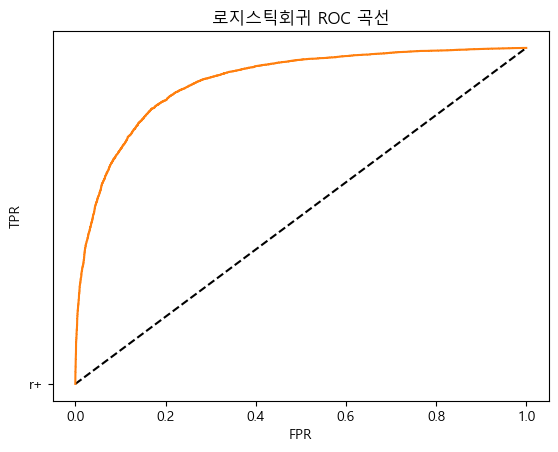

In [96]:
# ROC 커브 그려보기

fpr, tpr, thresholds = roc_curve(y_test, logi_1.predict_proba(x_test)[:, 1])
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(fpr, tpr, label = "LogisticRegression")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("로지스틱회귀 ROC 곡선")
plt.show()

In [70]:
# 교차검증 실시

cross_score = cross_val_score(logi_1, x, y, cv = 10, scoring ="roc_auc")
print("교차검증 점수:", cross_score)

교차검증 점수: [0.90116404 0.9016437  0.90277203 0.89909191 0.9018279  0.89470612
 0.89681803 0.89650312 0.90101478 0.88997544]


- 모델의 성능이 안정적이고 일관됨을 확인
  - ROC_AUC가 0.90
- 추후 새로운 컬럼이 데이터 양이 많아진다면 다른 기법 XGBoost 혹은 LightGBM을 고려해 볼만함

# RF(랜덤 포레스트)

- 위에 있던 기존의 분할 데이터 활용

In [73]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 14)

In [76]:
scores = cross_validate(rf, x_train, y_train, return_train_score = True, n_jobs = -1)

In [78]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.9983688898094449 0.9285832642916322


In [79]:
rf.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=14)

In [81]:
print(rf.feature_importances_)

[0.08693285 0.16085131 0.11367086 0.17022576 0.46831922]


In [83]:
rf = RandomForestClassifier(oob_score = True, n_jobs = -1, random_state =14)
rf.fit(x_train, y_train)
print(rf.oob_score_)

0.9272576636288318


In [85]:
# ROC_AUC_SCORE 확인하기
rf_proba = rf.predict_proba(x_test)[:, 1]

rf_roc_auc = roc_auc_score(y_test, rf_proba)

print("roc_auc 점수 : ", rf_roc_auc)

roc_auc 점수 :  0.9837240615027932


In [92]:
# Precision, Recall, F1-Score 확인하기
rf_prediction = rf.predict(x_test)
print(classification_report(y_test, rf_prediction))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      8471
           1       0.91      0.95      0.93      7623

    accuracy                           0.93     16094
   macro avg       0.93      0.93      0.93     16094
weighted avg       0.93      0.93      0.93     16094



In [93]:
# precision: positive라고 예측한 것 중에 얼마나 잘 맞았는지
## 0(유지 고객)의 경우 95%가 이탈하지 않았다고 예측
## 1(이탈 고객)의 경우 91%가 실제로 이탈했다고 예측

# recall: 실제 positive인 것을 얼마나 잘 예측했는지
## 0의 경우 실제로 이탈하지 않은 고 중 91%는 정확하게 예측
## 1의 경우 실제로 이탈한 고객 중 95%를 정확하게 예측

# F1-score: 조화평균

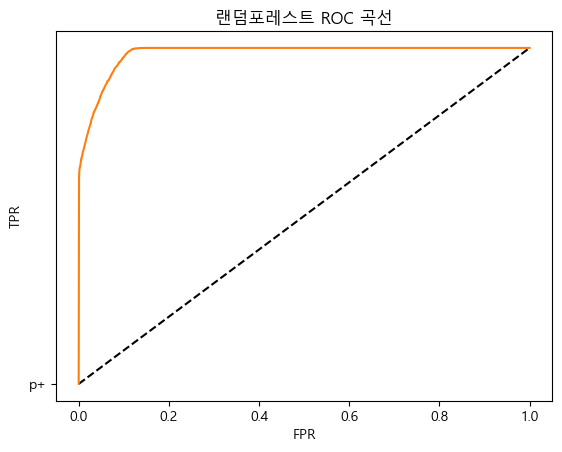

In [95]:
# ROC 커브 그려보기

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(x_test)[:, 1])
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(fpr, tpr, label = "RandomForest")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("랜덤포레스트 ROC 곡선")
plt.show()